<h1>ALA 470 Final Project</h1>

<p>By Haley Johnson</p>

In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt, mpld3
import matplotlib.style as style
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [2]:
sns.set_style("dark")
sns.color_palette("Paired")
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Load Data</h2>

In [3]:
df = pd.read_csv("fake.csv")

In [4]:
with open('stopwords.txt') as s:
    stopwords = s.read()

In [5]:
stopwords = stopwords.split(" ")

<h2>Preprocess</h2>

In [6]:
df = df[df['language'] == 'english']

<h3>Tokenize</h3>

In [7]:
df['text'] = df['text'].astype(str)
df['text_normalized'] = df['text'].str.lower()
df['sentences'] = df['text_normalized'].apply(lambda s: [sent for sent in nltk.sent_tokenize(s)])
df['tokens'] = df['text_normalized'].apply(lambda t: [word for sent in nltk.sent_tokenize(t) for word in nltk.word_tokenize(sent)])

In [8]:
df['title'] = df['title'].astype(str)
df['title_normalized'] = df['title'].str.lower()
df['title_tokens'] = df['title_normalized'].apply(nltk.word_tokenize)

In [9]:
df['non_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if w not in stopwords])
df['non_stopwords_count'] = df['non_stopwords'].apply(len)

In [10]:
df['title_no_stopwords'] = df['title_tokens'].apply(lambda t: [w for w in t if w not in stopwords])

<h2>Basic Text Exploration</h2>

In [11]:
targets = ['hillary clinton', 'bill clinton', 'donald trump', 'nancy pelosi', 'global warming', 'vaccines', 
           'democrat', 'republican', 'main stream media', 'washington d.c.', 'immigrants', 'election']

for target in targets:
    res = df['text_normalized'].str.contains(target)
    counts = df['text_normalized'].str.count(target)
    print(f"There are {res.sum()} articles that mention '{target}'")
    print(f"'{target}' is mentioned a total of {counts.sum()} times \n")
    
    

There are 3282 articles that mention 'hillary clinton'
'hillary clinton' is mentioned a total of 8390 times 

There are 651 articles that mention 'bill clinton'
'bill clinton' is mentioned a total of 1310 times 

There are 2831 articles that mention 'donald trump'
'donald trump' is mentioned a total of 5998 times 

There are 46 articles that mention 'nancy pelosi'
'nancy pelosi' is mentioned a total of 49 times 

There are 128 articles that mention 'global warming'
'global warming' is mentioned a total of 288 times 

There are 91 articles that mention 'vaccines'
'vaccines' is mentioned a total of 487 times 

There are 2693 articles that mention 'democrat'
'democrat' is mentioned a total of 7202 times 

There are 2023 articles that mention 'republican'
'republican' is mentioned a total of 4837 times 

There are 26 articles that mention 'main stream media'
'main stream media' is mentioned a total of 29 times 

There are 95 articles that mention 'washington d.c.'
'washington d.c.' is ment

In [12]:
sentences_lst = df['sentences'].to_list()
count = 0

for sentences in sentences_lst:
    for s in sentences:
        if re.match(r'\bhillary clinton\b', s):
            count += 1

<h2>NLTK</h2>

<h3>Top Tokens by Type</h3>

In [13]:
types = list(df['type'].unique())

In [14]:
top_tokens = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded_tokens = matches.explode('non_stopwords')
    exploded_tokens = exploded_tokens[pd.isnull(exploded_tokens['non_stopwords']) == False]
    top_tokens.append(exploded_tokens['non_stopwords'].value_counts())

<h3>Filter Out Puncutation Tokens</h3>

In [15]:
punctuation = ["'", "'", '"', '"', ".", "?", ",", "!", "-", ",", ".", '”', '“', ";", ":", "(", ")", "’",
               '–', "&", '``', "''", "'s", "...", ":", "@", "‘"]

In [16]:
for i in range(len(top_tokens)):
    current = top_tokens[i].reset_index().rename(columns = {'index': 'token', 'non_stopwords': 'count'} )
    current = current[current['token'].apply(lambda s: s not in punctuation) == True]
    top_tokens[i] = current

<h2>Visualize Tokens</h2>

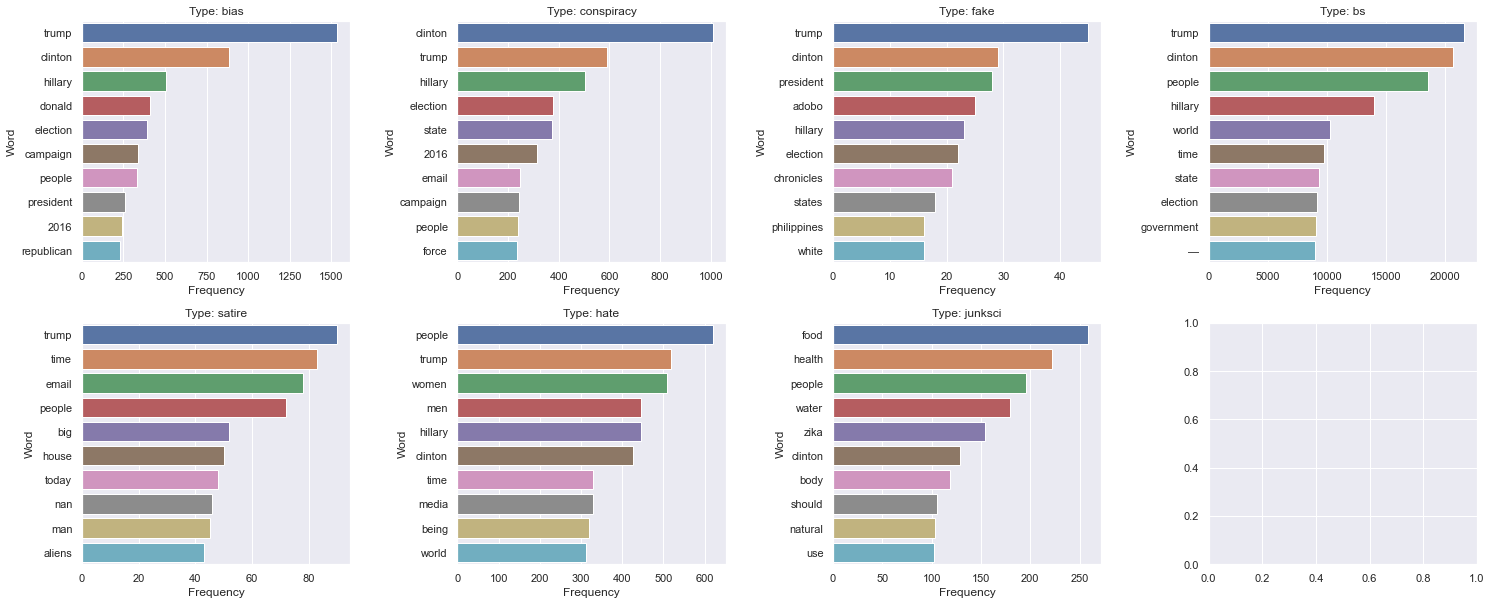

In [17]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    top = top_tokens[i].sort_values(by = 'count', ascending = False)[:10]
    grid = sns.barplot(x = top['count'], y = top['token'], ax = ax)
    grid.set(title = f"Type: {types[i]}", xlabel = 'Frequency', ylabel = 'Word')
    

<h3>Named Entity Recognition</h3>
<p><a href = "https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/">NLTK Parts of Speech Tags</a>

In [ ]:
def get_target_entities(s):
    '''
    Takes in a text fielld
    
    Returns all the entities 
    matching the labels in the
    targets list
    '''
    items = []
    s = str(s)
    tokens = [word for sent in nltk.sent_tokenize(s) for word in nltk.word_tokenize(sent)]
    targets = ['PERSON', 'GPE', 'ORGANIZATION', 'FACILITY', 'NORP', 'ORG', 
               'LOC', 'EVENT', 'LAW']
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        if entity.label() in targets:
            name = []
            for leaf in entity.leaves():
                name.append(leaf[0])
            items.append(" ".join(name))
    return items

In [ ]:
df['entities'] = df['non_stopwords'].apply(get_target_entities)

<h4>NER On Title</h4>

In [ ]:
df['title_entities'] = df['title_no_stopwords'].apply(get_target_entities)

<h2>Visualize Top Entities</h2>

<h3>Text</h3>

In [ ]:
top = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('entities')
    exploded = exploded[pd.isnull(exploded['entities']) == False]
    exploded['entities'] = exploded['entities'].apply(lambda s: s[1:])
    top.append(exploded['entities'].value_counts())

In [ ]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(27.5, 12.5)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    t = types[i]
    top_subset = top[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Fake News Articles", fontsize = 25)

<h3>Title</h3>

In [ ]:
top_ners = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('title_entities')
    exploded = exploded[pd.isnull(exploded['title_entities']) == False]
    exploded['title_entities'] = exploded['title_entities'].apply(lambda s: s[1:])
    top_ners.append(exploded['title_entities'].value_counts())

In [ ]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    t = types[i]
    top_subset = top_ners[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Titles of Fake News Articles", fontsize = 25)

<h2>Final Project Visualizations!</h2>

<a href="https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08">Seaborn Color Palettes</a>

In [18]:
regexs = ['clintons?', 'american?s?', 'china', 'washington', 'ryan', 'paul', 
          'putin', 'gingrich', 'russian?', 'african?', 'trump', 'obama', 
          'monsanto', 'islam', 'muslims?', 'leftists?', 'jews?', 
          'treasury', 'christians?', 'voter?s?d?', 'elections?', 'ballots?', 
          'vaccines?', 'gmos?', 'scientists?', 'immigrants?', 'emails?']

labels = ['Clinton', 'America', 'China', 'Washington', 'Paul Ryan', 'Rand Paul', 'Vladimir Putin', 
          'Newt Gingrich', 'Russia', 'Africa', 'Donald Trump', 'Barack Obama', 'Monsanto', 
          'Islam', 'Muslim', 'Leftist', 'Jew', 'Treasury', 'Christian', 'Voter', 
          'Election', 'Ballot', 'Vaccine', 'GMO', 'Scientist', 'Immigrants', 'Emails']

targets = sorted(list(zip(labels, regexs)))

In [19]:
palette = sns.cubehelix_palette(light = .7, n_colors = 25)

Text(0.5, 0.98, 'Most Common Things Mentioned in Fake News Articles by Type')

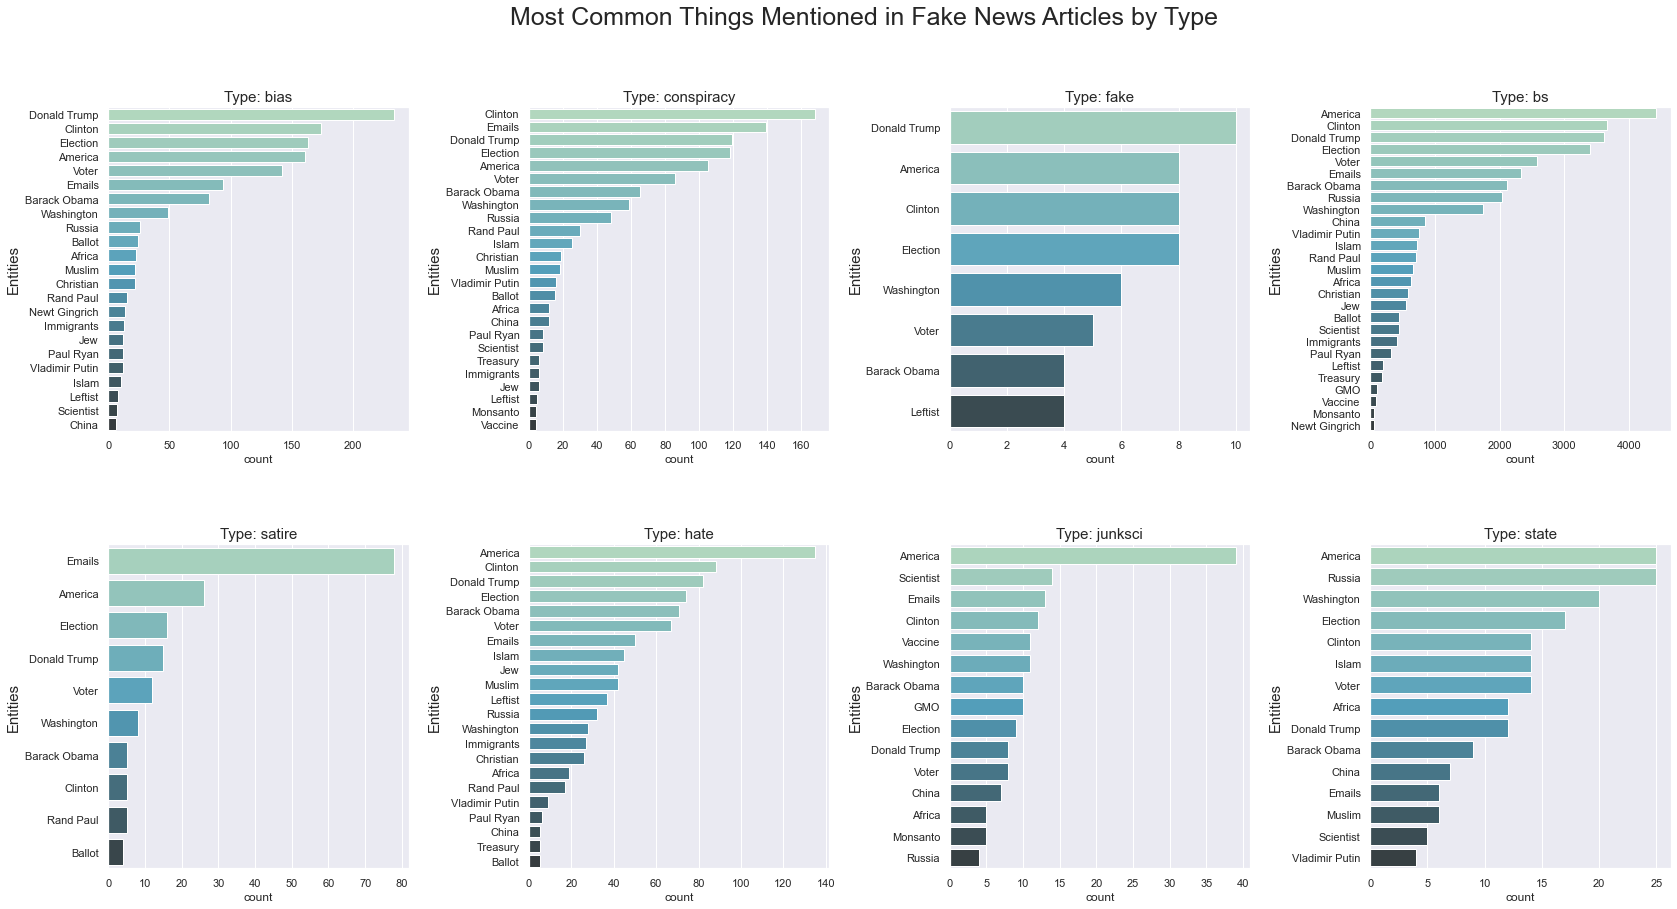

In [20]:
rcParams['figure.figsize'] = 28,14

fig, axes = plt.subplots(2, 4)
# fig.set_size_inches(40, 20)
fig.subplots_adjust(hspace = 0.35, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    t = types[i]
    matches = {}
    matches_df = df[df['type'] == t]
    for label, target in targets:
        matches[label] = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum()
    matches = {k:v for k, v in matches.items() if v > 3}    
    temp = pd.DataFrame(matches.items(), columns = ['entity', 'count'])
    temp = temp.sort_values(by = 'count', ascending = False)
    num_items = len(matches.keys())
    grid = sns.barplot(x = temp['count'], y = temp['entity'],
                       palette = sns.color_palette('GnBu_d',  num_items), ax = ax)
    grid.set_ylabel('Entities', fontsize = 15)
    grid.set_title(f"Type: {t}", fontsize = 15)
fig.suptitle("Most Common Things Mentioned in Fake News Articles by Type", fontsize = 25)

<h3>Variant With Percentages</h3>

In [51]:
bias = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), ('Campaign', 'campaigns?'),
        ('Republican', 'republicans?'), ('Democrat', 'democrats?'), ('Emails', 'emails?'), ('Voters', 'voters?'), 
        ('Newt Gingrich', 'gingrichs?'), ('FBI', 'fbi')]



conspiracy = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), ('Campaign', 'campaigns?'),
              ('Republican', 'republicans?'), ('Democrat', 'democrats?'), ('Emails', 'emails?'), 
              ('Barack Obama', 'obamas?'), ('Islam', 'islam'), ('WikiLeaks', 'wikileaks?')]


fake = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'),
        ('Phillippines', 'philippines?'), ('Barack Obama', 'obamas?'), ('Adobo\nChronicles', '(adobochron|adobo)'),
        ('Leftist', 'leftists?')]

bs = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), 
      ('Vladimir Putin', 'putins?'), ('Email', 'emails?'), ('Barack Obama', 'obamas?'), 
      ('China', 'china'), ('Rigged', '(rigs?|rigged)')]


satire = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), 
          ('Email', 'emails?'), ('Voter', 'voters?'), ('America', 'american?s?')]


hate = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), 
        ('Muslim', 'muslims?'), ('Jews', 'jews?'), ('Barack Obama', 'obamas?'), 
        ('Leftist', 'leftists'), ('David Duke', '(dukes?|dr.\bduke)')]

junksci = [('Zika', 'zika'), ('Vaccines', 'vaccines?'), ('Hillary Clinton', 'clintons?'),
           ('GMO', 'gmos?'), ('Africa', 'african?s?'), ('Monsanto', 'monsantos?'), ('Dentist', 'dentists?'), 
           ('Scientists', 'scientists?'), ('Environment', 'environments?')]


state = [('Donald Trump', r"trumps?"), ('Hillary Clinton', r'clintons?'), ('Election', 'elections?'), 
         ('Africa', 'african?s?'), ('China', 'chinas?'), ('Vladimir Putin', 'putins?'), ('Finland', 'finlands?'), 
         ('Islam', 'islam'), ('Hezbollah', 'hezbollahs?'), ('Ayatollah', 'ayatollahs?')]



targets = [bias, conspiracy, fake, bs, satire, hate, junksci, state]

<p>Color Palette from <a href="https://personal.sron.nl/~pault/">here</a></p>

In [52]:
colors = ['#77AADD', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#EEDD88',
          '#EE8866', '#FFAABB', '#CC6677','#AA4499']

<ipython-input-53-fed7b831cbc4>:5: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = 0.4, wspace = 0.7)
/Users/haleyjohnson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/haleyjohnson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/haleyjohnson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Text(0.5, 0.98, 'Most Common Terms Mentioned in Fake News Articles')

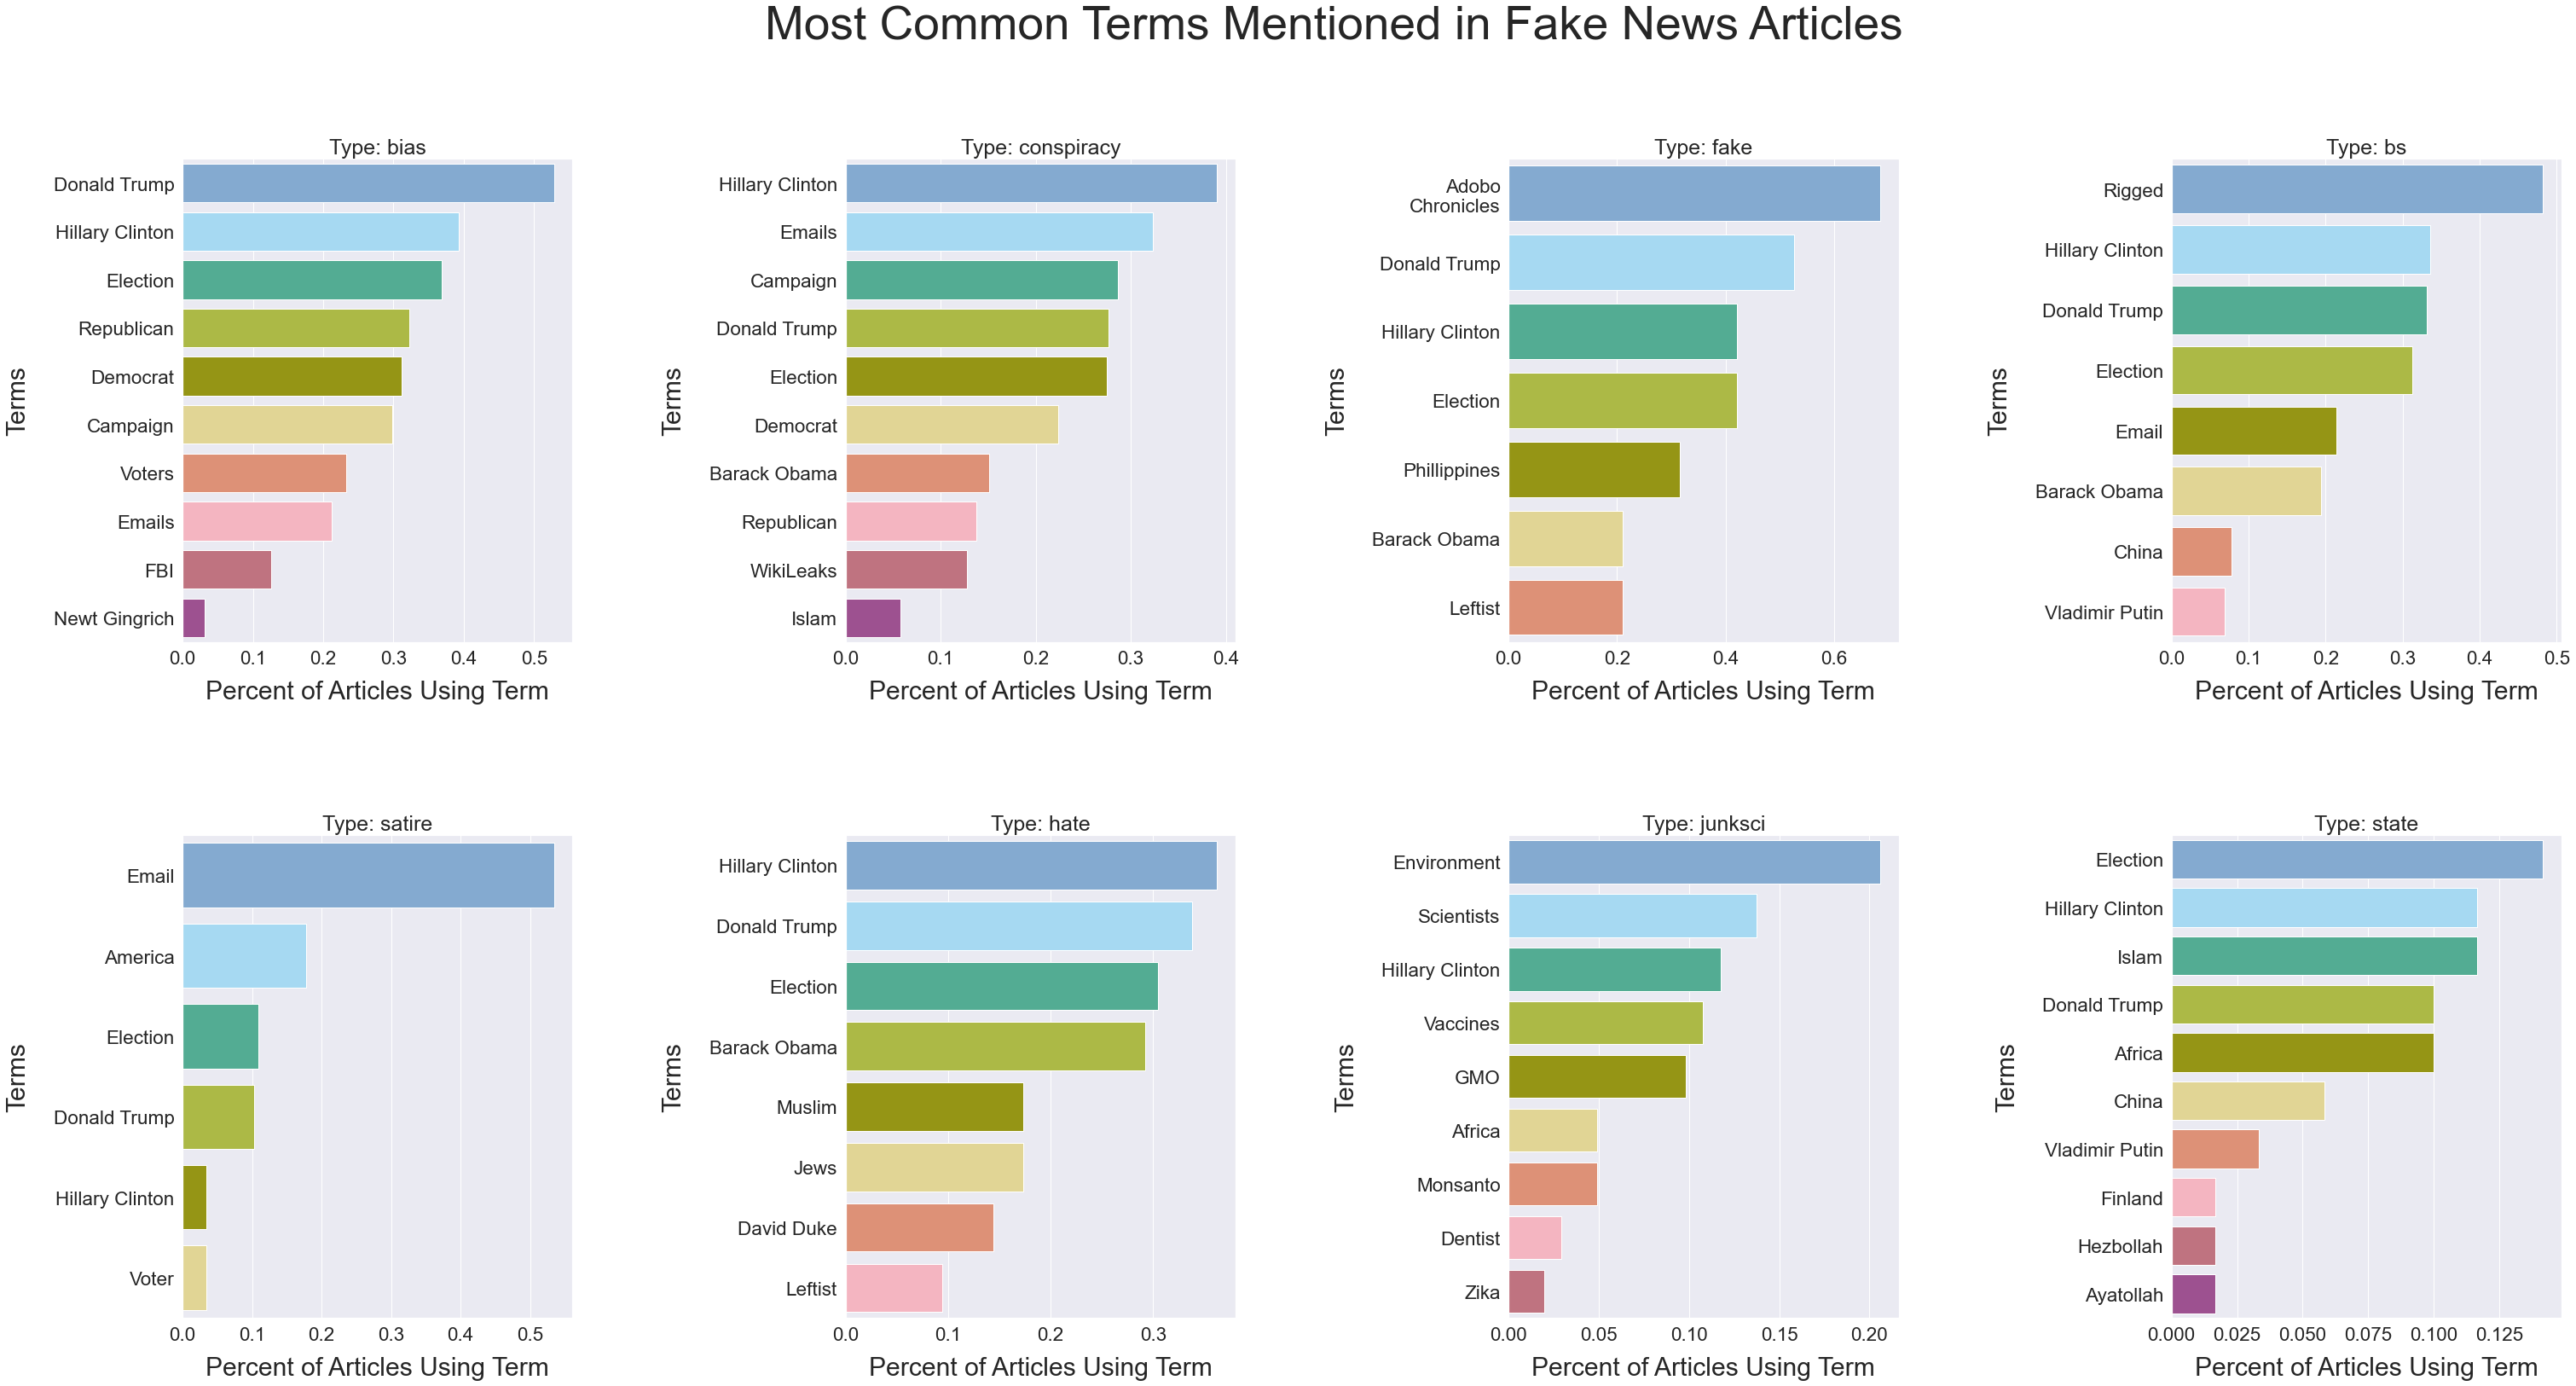

In [53]:
fig, axes = plt.subplots(2, 4, constrained_layout = True)
fig.set_size_inches(50, 25)
fig.subplots_adjust(hspace = 0.4, wspace = 0.7)

for i, ax in enumerate(axes.flatten()):
    t = types[i]
    matches = {}
    matches_df = df[df['type'] == t]
    
    for label, target in targets[i]:
        amount = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum() / len(matches_df)
        matches[label] = amount
         
    temp = pd.DataFrame(matches.items(), columns = ['entity', 'percent'])
    temp = temp.sort_values(['percent'], ascending = False)
    num_items = len(matches.keys())
    
    grid = sns.barplot(x = temp['percent'], y = temp['entity'],
                       palette = sns.color_palette(colors), ax = ax)
    
    grid.tick_params(labelsize = 22.5)
    grid.set_ylabel('Terms', fontsize = 30, labelpad = 27.5)
    grid.set_xlabel('Percent of Articles Using Term',  fontsize = 30, labelpad = 15)
    grid.set_title(f"Type: {t}", fontsize = 25)
    

fig.suptitle("Most Common Terms Mentioned in Fake News Articles", fontsize = 55)

In [54]:
fig.savefig('ala_470_viz.png')